# Assignment 1B - Question 1
## Training and Adapting Deep Networks

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.io import loadmat

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.preprocessing.image import Iterator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Load data from training and testing sets

Use scipy.io loadmat function

In [2]:
train = loadmat('Data/Q1/q1_train.mat')
test = loadmat('Data/Q1/q1_test.mat')

### Sanity check

In [3]:
train['train_Y'].shape

(1000, 1)

In [4]:
test['test_Y'].shape

(10000, 1)

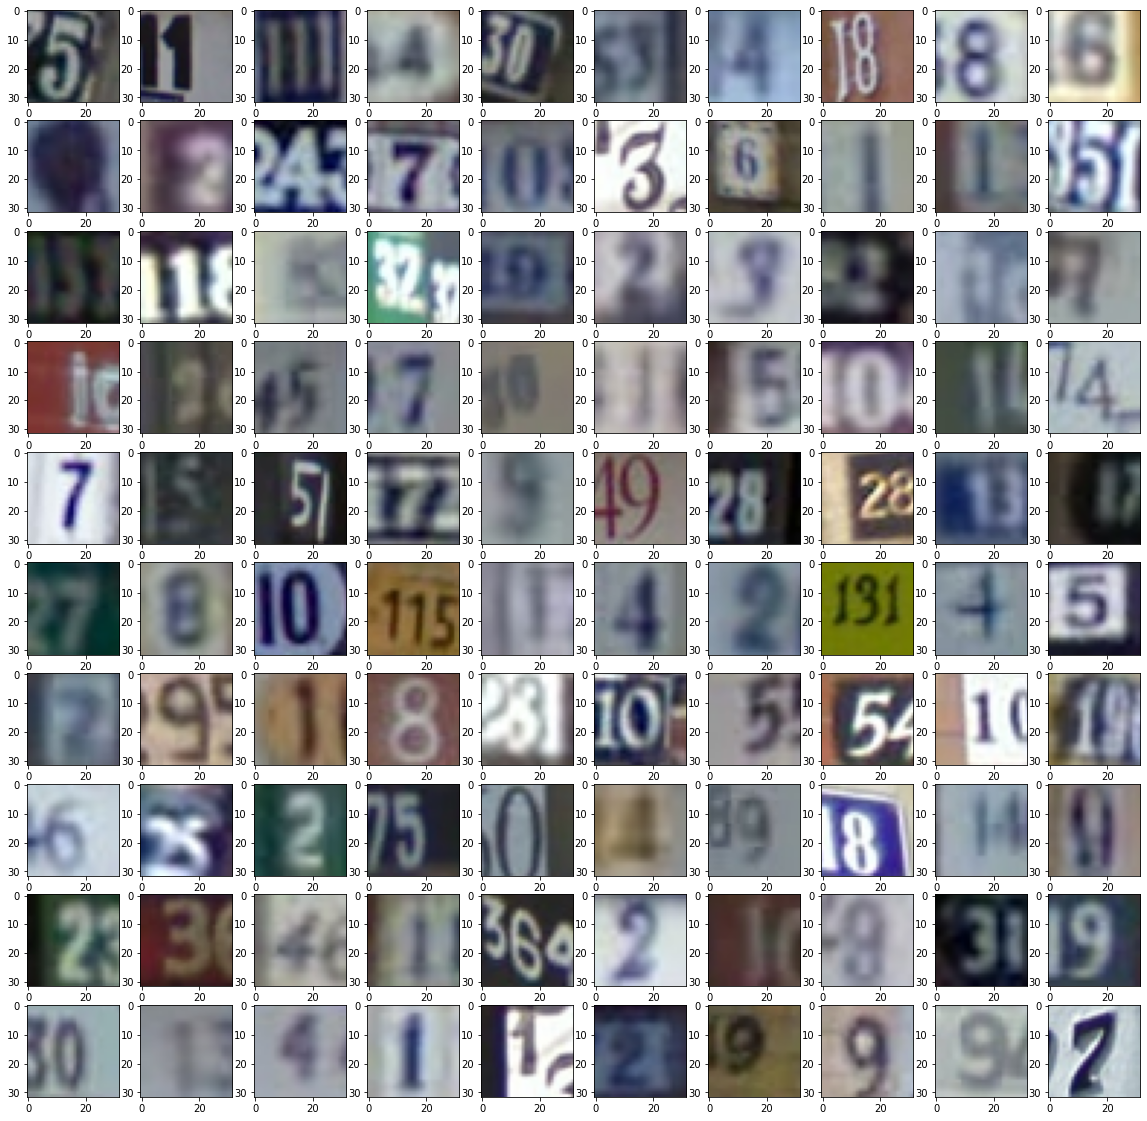

In [3]:
(x_test, y_test) = (test['test_X'], test['test_Y'])
x_test = x_test.astype('float32') / 255
x_test = np.transpose(x_test, (3,0,1,2))
fig = plt.figure(figsize=[20, 20])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_test[i,:,:,:])

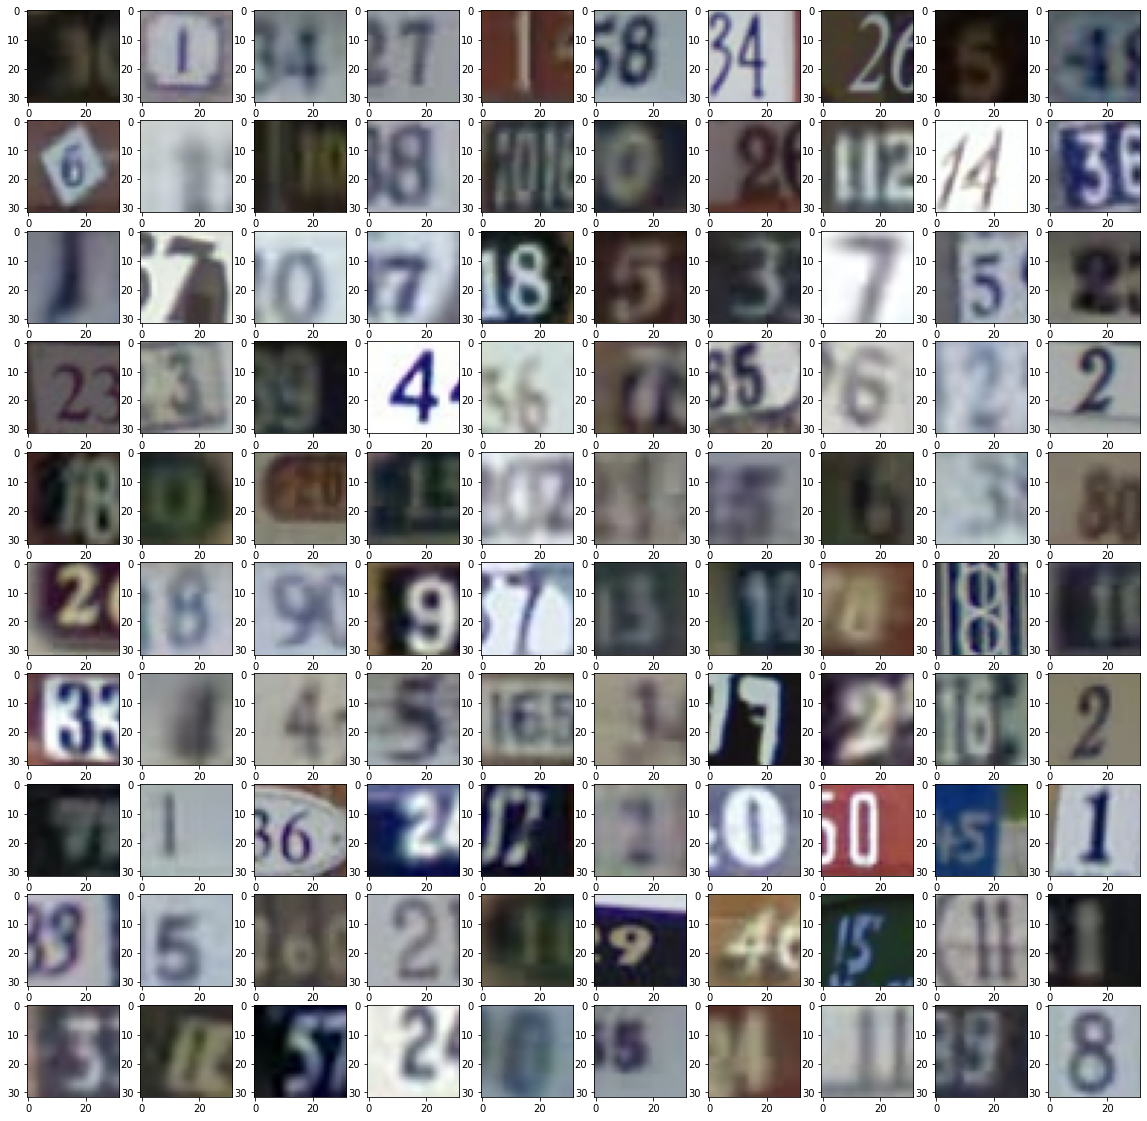

In [4]:
(x_train, y_train) = (train['train_X'], train['train_Y'])
x_train = x_train.astype('float32') / 255
x_train = np.transpose(x_train, (3,0,1,2))
fig = plt.figure(figsize=[20, 20])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:,:,:])

### Keras Model

Taken from Week 4 example 2

In [7]:
def get_model():
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(11, activation='softmax')(x)

    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_CNN_Model')
    
    return model_cnn

In [8]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
history = model_cnn.fit(x_train, y_train,
                        batch_size=32,
                        epochs=50,
                        validation_split=0.2, verbose=True)

Epoch 1/50
25/25 [==============================] - 1s 12ms/step - loss: 2.3571 - accuracy: 0.1258 - val_loss: 2.2942 - val_accuracy: 0.1600
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 2.3046 - accuracy: 0.1571 - val_loss: 2.2606 - val_accuracy: 0.1600
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 2.2845 - accuracy: 0.1782 - val_loss: 2.2140 - val_accuracy: 0.1750
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 2.2338 - accuracy: 0.1868 - val_loss: 2.1790 - val_accuracy: 0.2100
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 2.1940 - accuracy: 0.2261 - val_loss: 2.1372 - val_accuracy: 0.2400
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 2.1451 - accuracy: 0.2461 - val_loss: 2.1368 - val_accuracy: 0.2300
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 2.0703 - accuracy: 0.2823 - val_loss: 2.0074 - val_accuracy: 0.3050
Epoch 8/50
25/25 [=

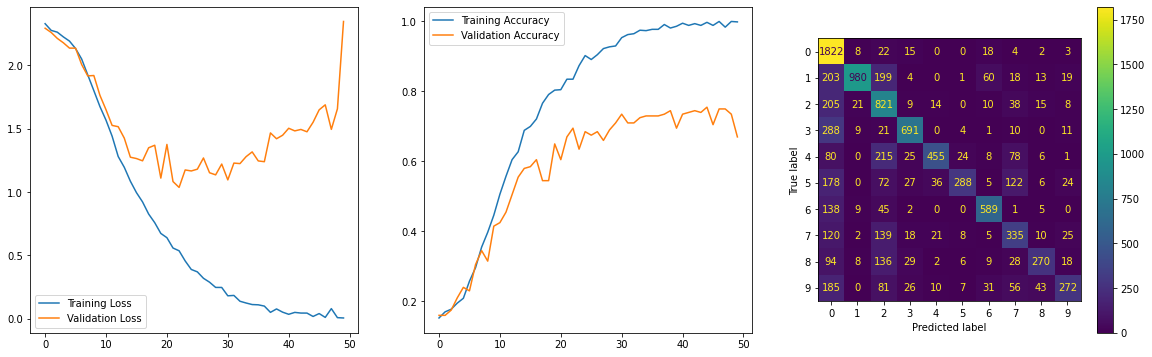

In [9]:
def plot_training(history, model, x_test, y_test):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    ax = fig.add_subplot(1, 3, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
plot_training(history, model_cnn, x_test, y_test)

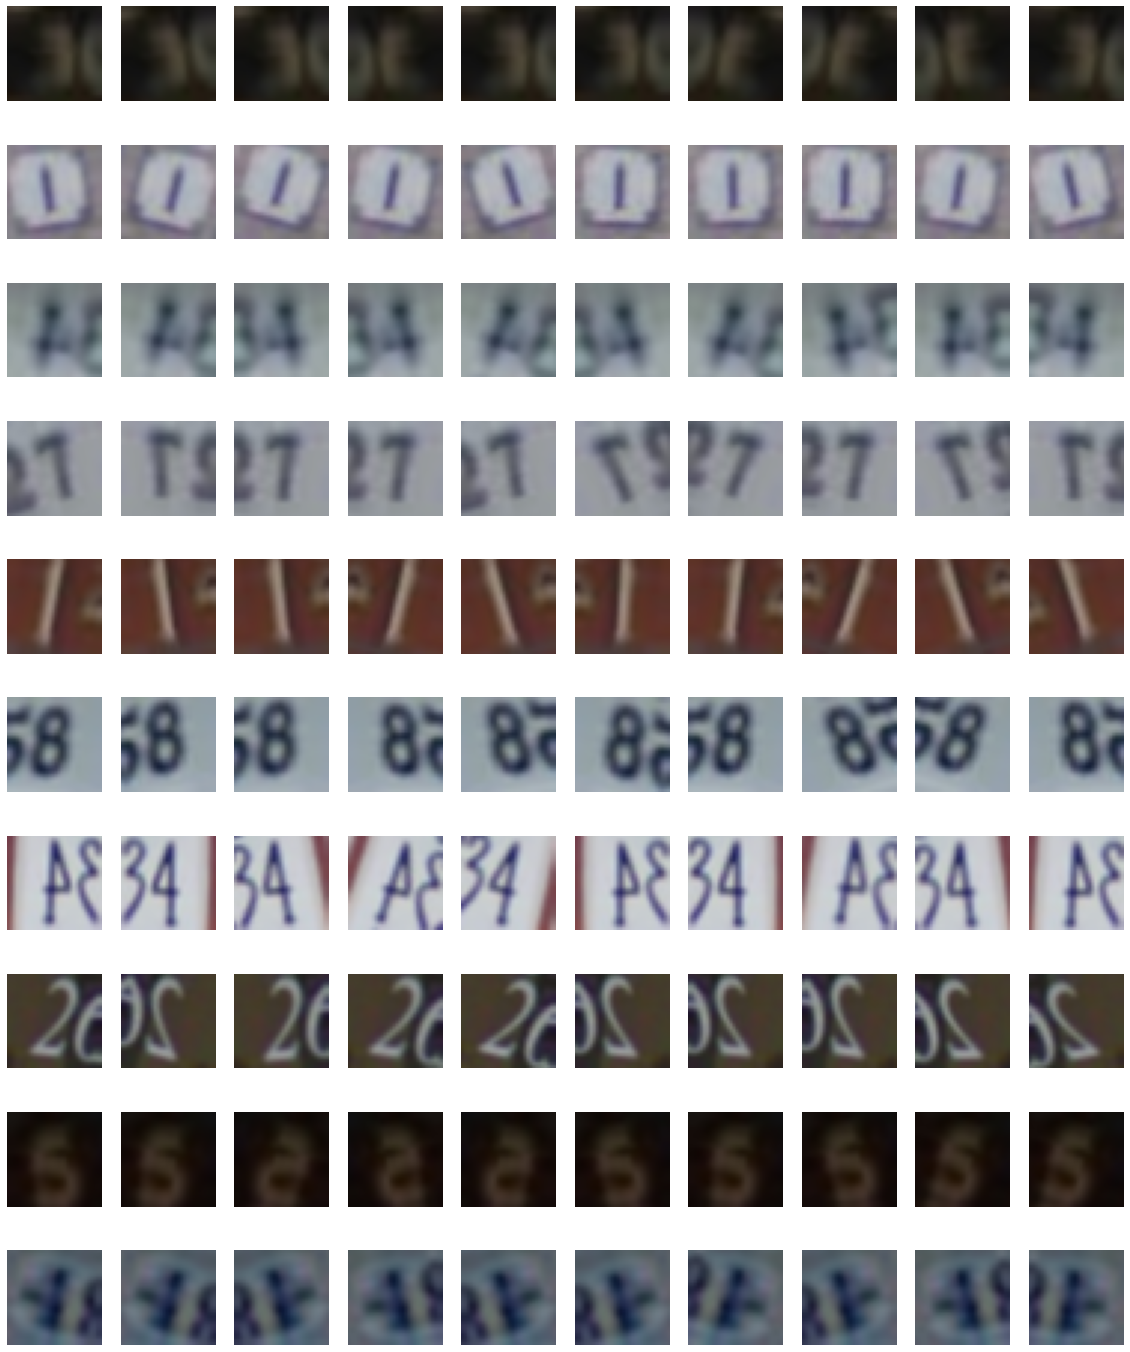

In [5]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.05),
  layers.experimental.preprocessing.RandomZoom(0.025),
  layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025))
])

fig = plt.figure(figsize=[20, 25])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(x_train[i,:,:,:],0))
        plt.imshow(augmented_image[0])
        plt.axis("off")

In [8]:
def get_model_augment():
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    augmented = data_augmentation(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(augmented)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(11, activation='softmax')(x)

    model_cnn_aug = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_CNN_Model')
    
    return model_cnn_aug

In [10]:
model_cnn_aug = get_model_augment()
model_cnn_aug.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
history = model_cnn_aug.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.2, verbose=True)

Epoch 1/100
25/25 [==============================] - 1s 20ms/step - loss: 2.3423 - accuracy: 0.1351 - val_loss: 2.2820 - val_accuracy: 0.1600
Epoch 2/100
25/25 [==============================] - 0s 16ms/step - loss: 2.2789 - accuracy: 0.1855 - val_loss: 2.2231 - val_accuracy: 0.1950
Epoch 3/100
25/25 [==============================] - 0s 16ms/step - loss: 2.2718 - accuracy: 0.1533 - val_loss: 2.2388 - val_accuracy: 0.1600
Epoch 4/100
25/25 [==============================] - 0s 16ms/step - loss: 2.2644 - accuracy: 0.1907 - val_loss: 2.2069 - val_accuracy: 0.2150
Epoch 5/100
25/25 [==============================] - 0s 16ms/step - loss: 2.2420 - accuracy: 0.1960 - val_loss: 2.1986 - val_accuracy: 0.2100
Epoch 6/100
25/25 [==============================] - 0s 16ms/step - loss: 2.2508 - accuracy: 0.1947 - val_loss: 2.1985 - val_accuracy: 0.1900
Epoch 7/100
25/25 [==============================] - 0s 16ms/step - loss: 2.2203 - accuracy: 0.2089 - val_loss: 2.1825 - val_accuracy: 0.2350
Epoch 

In [ ]:
def plot_training(history, model, x_test, y_test):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    ax = fig.add_subplot(1, 3, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
plot_training(history, model_cnn_aug, x_test, y_test)
